# Using scanpy_plus
This is not a replacement for scanpy, but a supplement to it.

It provides additional functions that make working with single cell data easier.

In [2]:
import scanpy as sc
import scanpy_plus as scp
import anndata as ad
import seaborn as sns
import torch
import tempfile
import scvi

/Users/vm11/Soft/scanpy_plus/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor="white")
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

/Users/vm11/Soft/scanpy_plus/venv/lib/python3.13/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/Context.cpp:85.)
  _C._set_float32_matmul_precision(precision)


# Integrate using scanpy_plus
Presently this has [scvi][ https://docs.scvi-tools.org/en/1.3.2/tutorials/notebooks/quick_start/api_overview.html ]. 

In [5]:
adata = scvi.data.heart_cell_atlas_subsampled()
adata

INFO     Downloading file at data/hca_subsampled_20k.h5ad                                                          
Downloading...: 100%|██████████| 65714/65714.0 [00:03<00:00, 17398.72it/s]


AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'

In [ ]:
# Using scanpy_plus describe function.
# This function provides an extended description of the AnnData object.
# Tells you what is likely state of adata.X - raw, normalized, log1p transformed, scaled.
# X min and max values - Tells you if it is logged or not.
# For top 100 cells it prints the total counts (min and max). Tells you if data is normalized or not
adata.describe()

**** Highly likely data is raw
-----
(X) min = 0.0 | max = 7468.0 
-----
(head 100 cells) umi_sum min =  529.0 | umi_sum max =  9042.0 | cellmean =   2729.3535
-----
AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'


In [9]:
adata.obs['source'].value_counts()

source
Nuclei    13733
CD45+      3155
Cells      1753
Name: count, dtype: int64

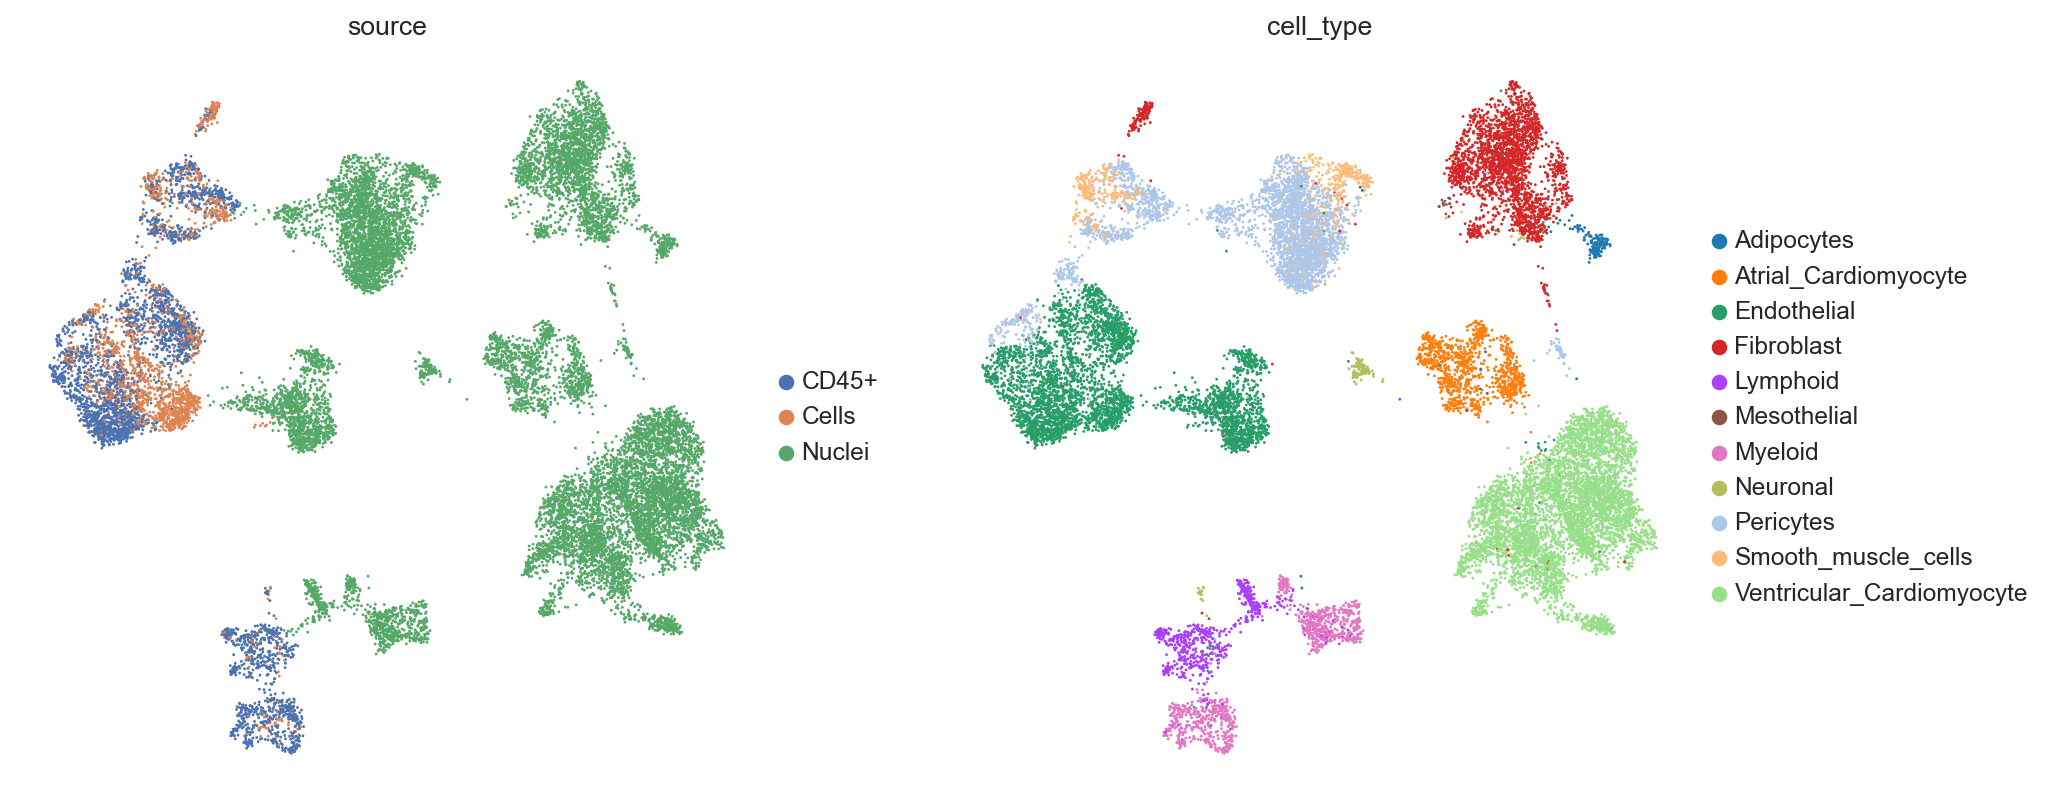

In [ ]:
# General preprocessing. Not specific to scanpy_plus
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()
adata.raw = adata # Generally this is not recommended for raw counts, but for simplicity in this tutorial we do it.
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,  n_top_genes=2000, subset=True, batch_key="source")
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["source", "cell_type"])


In [14]:
raw_count_layer="counts"
categorical_covariate_keys=["cell_source", "donor"],
continuous_covariate_keys=["percent_mito", "percent_ribo"]


In [15]:
scp.tl.run_scvi(
    adata[:,adata.var.highly_variable],
    batch_key="source",
    categorical_covariate_keys = categorical_covariate_keys,
    continuous_covariate_keys = continuous_covariate_keys,
    max_epochs=1
)


ModuleNotFoundError: No module named 'loguru'